In [1]:
import torch
import numpy as np
import torch.nn as nn
from mass_spring import get_dataset
from tqdm import tqdm
from torch.autograd import grad
torch.manual_seed(42)
np.random.seed(42)

from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
class MLP1H_Separable_Hamilt(nn.Module):
    def __init__(self, n_hidden, input_size):
        super(MLP1H_Separable_Hamilt, self).__init__()
        self.linear_K1 = nn.Linear(input_size, n_hidden)
        self.linear_K2 = nn.Linear(n_hidden, 1)
        self.linear_P1 = nn.Linear(input_size, n_hidden)
        self.linear_P2 = nn.Linear(n_hidden, 1)

    def kinetic_energy(self, p):
        h_pre = self.linear_K1(p)
        h = h_pre.tanh_()
        return self.linear_K2(h)

    def potential_energy(self, q):
        h_pre = self.linear_P1(q)
        h = h_pre.tanh_()
        return self.linear_P2(h)

    def forward(self, p, q):
        return self.kinetic_energy(p) + self.potential_energy(q)
    
class MLP2H_Separable_Hamilt(nn.Module):
    def __init__(self, n_hidden, input_size):
        super(MLP2H_Separable_Hamilt, self).__init__()
        self.linear_K1 = nn.Linear(input_size, n_hidden)
        self.linear_K1B = nn.Linear(n_hidden, n_hidden)
        self.linear_K2 = nn.Linear(n_hidden, 1)
        self.linear_P1 = nn.Linear(input_size, n_hidden)
        self.linear_P1B = nn.Linear(n_hidden, n_hidden)
        self.linear_P2 = nn.Linear(n_hidden, 1)

    def kinetic_energy(self, p):
        h_pre = self.linear_K1(p)
        h = h_pre.tanh_()
        h_pre_B = self.linear_K1B(h)
        h_B = h_pre_B.tanh_()
        return self.linear_K2(h_B)

    def potential_energy(self, q):
        h_pre = self.linear_P1(q)
        h = h_pre.tanh_()
        h_pre_B = self.linear_P1B(h)
        h_B = h_pre_B.tanh_()
        return self.linear_P2(h_B)

    def forward(self, p, q):
        return self.kinetic_energy(p) + self.potential_energy(q)


class MLP3H_Separable_Hamilt(nn.Module):
    def __init__(self, n_hidden, input_size):
        super(MLP3H_Separable_Hamilt, self).__init__()
        self.linear_K0 = nn.Linear(input_size, n_hidden)
        self.linear_K1 = nn.Linear(n_hidden, n_hidden)
        self.linear_K2 = nn.Linear(n_hidden, n_hidden)
        self.linear_K3 = nn.Linear(n_hidden, 1)
        self.linear_P0 = nn.Linear(input_size, n_hidden)
        self.linear_P1 = nn.Linear(n_hidden, n_hidden)
        self.linear_P2 = nn.Linear(n_hidden, n_hidden)
        self.linear_P3 = nn.Linear(n_hidden, 1)

    def kinetic_energy(self, p):
        h = self.linear_K0(p).tanh_()
        h = self.linear_K1(h).tanh_()
        h = self.linear_K2(h).tanh_()
        return self.linear_K3(h)

    def potential_energy(self, q):
        h = self.linear_P0(q).tanh_()
        h = self.linear_P1(h).tanh_()
        h = self.linear_P2(h).tanh_()
        return self.linear_P3(h)

    def forward(self, p, q):
        return self.kinetic_energy(p) + self.potential_energy(q)
        
class MLP_General_Hamilt(nn.Module):
    def __init__(self, n_input, n_hidden):
        super(MLP_General_Hamilt, self).__init__()
        self.linear1 = nn.Linear(n_input, n_hidden)
        self.linear1B = nn.Linear(n_hidden, n_hidden)
        self.linear2 = nn.Linear(n_hidden, 1)

    def forward(self, p, q):
        pq = torch.cat((p, q), 1)
        h_pre = self.linear1(pq)
        h = h_pre.tanh_()
        h_pre_B = self.linear1B(h)
        h_B = h_pre_B.tanh_()
        return self.linear2(h_B)

In [20]:
def leapfrog(p_0, q_0, Func, T, dt, volatile=True, is_Hamilt=True, device='cpu', use_tqdm=False):

    trajectories = torch.empty((T, p_0.shape[0], 2 * p_0.shape[1]), requires_grad=False).to(device)

    p = p_0
    q = q_0
    p.requires_grad_()
    q.requires_grad_()

    if use_tqdm:
        range_of_for_loop = tqdm(range(T))
    else:
        range_of_for_loop = range(T)

    if is_Hamilt:
        hamilt = Func(p, q)
        dpdt = -grad(hamilt.sum(), q, create_graph=not volatile)[0]

        for i in range_of_for_loop:
            p_half = p + dpdt * (dt / 2)

            if volatile:
                trajectories[i, :, :p_0.shape[1]] = p.detach()
                trajectories[i, :, p_0.shape[1]:] = q.detach()
            else:
                trajectories[i, :, :p_0.shape[1]] = p
                trajectories[i, :, p_0.shape[1]:] = q

            hamilt = Func(p_half, q)
            dqdt = grad(hamilt.sum(), p, create_graph=not volatile)[0]

            q_next = q + dqdt * dt

            hamilt = Func(p_half, q_next)
            dpdt = -grad(hamilt.sum(), q_next, create_graph=not volatile)[0]

            p_next = p_half + dpdt * (dt / 2)

            p = p_next
            q = q_next

    else:
        dim = p_0.shape[1]
        time_drvt = Func(torch.cat((p, q), 1))
        dpdt = time_drvt[:, :dim]

        for i in range_of_for_loop:
            p_half = p + dpdt * (dt / 2)

            if volatile:
                trajectories[i, :, :dim] = p.detach()
                trajectories[i, :, dim:] = q.detach()
            else:
                trajectories[i, :, :dim] = p
                trajectories[i, :, dim:] = q

            time_drvt = Func(torch.cat((p_half, q), 1))
            dqdt = time_drvt[:, dim:]

            q_next = q + dqdt * dt

            time_drvt = Func(torch.cat((p_half, q_next), 1))
            dpdt = time_drvt[:, :dim]

            p_next = p_half + dpdt * (dt / 2)

            p = p_next
            q = q_next

    return trajectories


def euler(p_0, q_0, Func, T, dt, volatile=True, is_Hamilt=True, device='cpu', use_tqdm=False):

    trajectories = torch.empty((T, p_0.shape[0], 2 * p_0.shape[1]), requires_grad=False).to(device)

    p = p_0
    q = q_0
    p.requires_grad_()
    q.requires_grad_()

    if use_tqdm:
        range_of_for_loop = tqdm(range(T))
    else:
        range_of_for_loop = range(T)

    if is_Hamilt:

        for i in range_of_for_loop:

            if volatile:
                trajectories[i, :, :p_0.shape[1]] = p.detach()
                trajectories[i, :, p_0.shape[1]:] = q.detach()
            else:
                trajectories[i, :, :p_0.shape[1]] = p
                trajectories[i, :, p_0.shape[1]:] = q

            hamilt = Func(p, q)
            dpdt = -grad(hamilt.sum(), q, create_graph=not volatile)[0]
            dqdt = grad(hamilt.sum(), p, create_graph=not volatile)[0]

            p_next = p + dpdt * dt
            q_next = q + dqdt * dt

            p = p_next
            q = q_next

    else:
        dim = p_0.shape[1]

        for i in range_of_for_loop:

            if volatile:
                trajectories[i, :, :dim] = p.detach()
                trajectories[i, :, dim:] = q.detach()
            else:
                trajectories[i, :, :dim] = p
                trajectories[i, :, dim:] = q

            time_drvt = Func(torch.cat((p, q), 1))
            dpdt = time_drvt[:, :dim]
            dqdt = time_drvt[:, dim:]

            p_next = p + dpdt * dt
            q_next = q + dqdt * dt

            p = p_next
            q = q_next

    return trajectories


def numerically_integrate(integrator, p_0, q_0, model, method, T, dt, volatile, device, coarsening_factor=1):
    if (coarsening_factor > 1):
        fine_trajectory = numerically_integrate(integrator, p_0, q_0, model, method, T * coarsening_factor, dt / coarsening_factor, volatile, device)
        trajectory_simulated = fine_trajectory[np.arange(T) * coarsening_factor, :, :]
        return trajectory_simulated
    if (method == 5):
        if (integrator == 'leapfrog'):
            trajectory_simulated = leapfrog(p_0, q_0, model, T, dt, volatile=volatile, device=device)
        elif (integrator == 'euler'):
            trajectory_simulated = euler(p_0, q_0, model, T, dt, volatile=volatile, device=device)
    elif (method == 1):
        if (integrator == 'leapfrog'):
            trajectory_simulated = leapfrog(p_0, q_0, model, T, dt, volatile=volatile, is_Hamilt=False, device=device)
        elif (integrator == 'euler'):
            trajectory_simulated = euler(p_0, q_0, model, T, dt, volatile=volatile, is_Hamilt=False, device=device)
    else:
        trajectory_simulated = model(torch.cat([p_0, q_0], dim=1), T)
    return trajectory_simulated


In [21]:
def predict(test_data, model, method, integrator, device, T_test, dt):
    print(integrator)
    dim = 20
    model = model.to(device).to(dtype=torch.float64)
    model.eval()

    z_0_npy = test_data[0, :, :]

    z_0 = torch.from_numpy(z_0_npy).to(device).to(dtype=torch.float64)

    trajectory_predicted = numerically_integrate(integrator=integrator, p_0=z_0[:, :dim], q_0=z_0[:, dim:], model=model, \
        method=method, T=T_test, dt=dt, volatile=True, device=device, coarsening_factor=1).to(torch.float64)

    return trajectory_predicted

In [22]:
def train(integrator_train = 'euler'):
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    n_samples = 1000
    batch_size = 32
    dim = 20
    max_t = 100
    n_epochs = 100
    # integrator_train = integrator_train
    dt = 0.1
    method = 5
    # data = get_dataset(seed = 42, samples = n_samples, noise = False)
    # x = np.transpose(data['x'], (1, 0, 2))
    # test_x = np.transpose(data['test_x'], (1, 0, 2))
    data = np.load("train_data_chain_newA.npy")
    test_data = np.load("test_data_chain_newA.npy")
    # data = x.copy()
    # test_data = test_x.copy()
    mse = nn.MSELoss()
    z_0_npy = data[0, :, :]
    model = MLP1H_Separable_Hamilt(2048, dim)
    model = model.to(device).to(dtype=torch.float64)
    # data = data.to(device)
    # test_data = test_data.to(device)
    # scheduler = ReduceLROnPlateau(opt_model, 'min', patience = scheduler_patience, verbose=True, factor=scheduler_factor)
    params_lst = model.parameters()
    opt_model = torch.optim.Adam(params_lst, lr=0.001)
    loss_record = []
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    for epoch in tqdm(range(n_epochs)):
        total_error = 0
        perm = torch.randperm(n_samples).numpy().tolist()
        data_permed = data[:, perm, :]
        z_0_npy_permed = z_0_npy[perm, :]
        for i in range(0, n_samples, batch_size):
            opt_model.zero_grad()
            if i+batch_size > n_samples:
                break
            batch = data_permed[:max_t, i:(i+batch_size), :]
            z_0_batch_npy = z_0_npy_permed[i:(i+batch_size), :]
            z_0_batch = torch.from_numpy(z_0_batch_npy).to(dtype=torch.float64)
            z_0_batch_device = z_0_batch.to(device)
            p_0 = z_0_batch_device[:, :dim]
            q_0 = z_0_batch_device[:, dim:]
            trajectory_simulated = numerically_integrate(integrator=integrator_train, p_0=p_0, q_0=q_0, model=model, \
                        method=method, T=max_t, dt=dt, volatile=False, device=device, coarsening_factor=1).to(torch.float64)
            error_total = mse(trajectory_simulated[:max_t, :, :], torch.from_numpy(batch[:max_t, :, :]).to(device).to(dtype=torch.float64))
            error_total.backward()
            opt_model.step()
            total_error += error_total.item() * batch_size
        avg_loss_epoch = total_error/n_samples
        loss_record.append(avg_loss_epoch)
    return model, loss_record, test_data, device

In [ ]:
model_euler, loss_euler, test_data, device = train("euler")
model_leapfrog, loss_leapfrog, test_data, device = train("leapfrog")

 82%|██████████████████████████████████▍       | 82/100 [54:59<09:52, 32.90s/it]

In [9]:
print(loss_euler)
print(loss_leapfrog)

[0.5235827956453751, 0.4780518174029126, 0.43804988887088514, 0.4216869777390221, 0.39226752431046724, 0.3667488071077468, 0.3517663808869517, 0.32668403899142734, 0.29714085381996386, 0.27981098789603875, 0.26135170132713037, 0.2368544082098451, 0.21817302747176093, 0.19888989633687412, 0.18108961123398387, 0.16663278201078793, 0.14527813332966838, 0.1311217844199969, 0.11899934095827941, 0.10486724917349885, 0.094858652563596, 0.08333260345089454, 0.07482242690720065, 0.06657967620012215, 0.06049566970520418, 0.05525909596985937, 0.050502311970434886, 0.045262992336477514, 0.04150912547276343, 0.03750164544773263, 0.03440202286313616, 0.031807402194281596, 0.02899120761524925, 0.027392489193558717, 0.02498395970953599, 0.02332047851023021, 0.02137054185821569, 0.01988886145174151, 0.01856895138208701, 0.01681667130580414, 0.016074354743531007, 0.015000176399742764, 0.013812770355024815, 0.01279177402904308, 0.011976939620139576, 0.01114929930184389, 0.010568138202226861, 0.0097508458

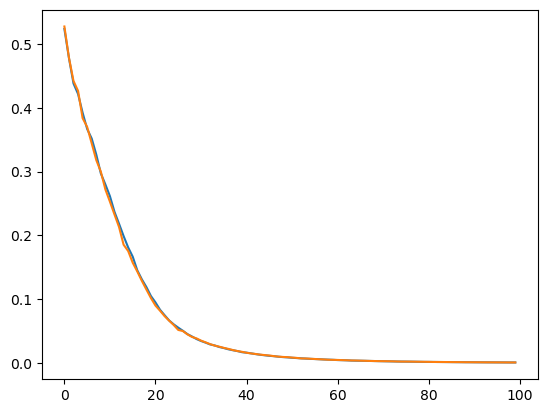

In [14]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_euler)), loss_euler, label = "euler")
plt.plot(range(len(loss_leapfrog)), loss_leapfrog, label = "leapfrog")

plt.show()

In [15]:
predicted_trajectory_euler = predict(test_data, model_euler, 5, "euler", device, 50, 0.01).cpu().numpy()
predicted_trajectory_leapfrog = predict(test_data, model_leapfrog, 5, "leapfrog", device, 50, 0.01).cpu().numpy()
test_error_euler = np.linalg.norm(predicted_trajectory_euler - test_data, axis = -1)
test_error_leapfrog = np.linalg.norm(predicted_trajectory_leapfrog - test_data, axis = -1)

euler
euler
leapfrog
leapfrog


In [16]:
print(test_error_euler.mean(axis = 1))
print(test_error_leapfrog.mean(axis = 1))

[0.         0.07401224 0.14802408 0.22203424 0.29604148 0.37004448
 0.44404199 0.51803274 0.59201548 0.66598892 0.73995181 0.81390285
 0.88784078 0.96176435 1.03567227 1.10956328 1.18343613 1.25728951
 1.3311222  1.40493291 1.47872038 1.55248334 1.62622053 1.69993067
 1.77361251 1.84726478 1.92088624 1.9944756  2.0680316  2.14155298
 2.2150385  2.28848687 2.36189686 2.43526719 2.50859663 2.58188391
 2.65512777 2.72832694 2.8014802  2.87458627 2.94764392 3.02065189
 3.09360893 3.16651381 3.23936526 3.31216204 3.38490291 3.45758664
 3.53021196 3.60277765]
[0.         0.07397578 0.14795116 0.22192488 0.29589568 0.36986227
 0.44382338 0.51777775 0.59172411 0.66566118 0.73958771 0.81350242
 0.88740402 0.96129127 1.0351629  1.10901762 1.18285418 1.2566713
 1.33046774 1.40424221 1.47799345 1.5517202  1.62542117 1.69909512
 1.77274078 1.84635688 1.91994218 1.99349539 2.06701525 2.14050051
 2.21394991 2.28736219 2.36073608 2.43407034 2.50736371 2.58061493
 2.65382275 2.72698589 2.80010312 2.873

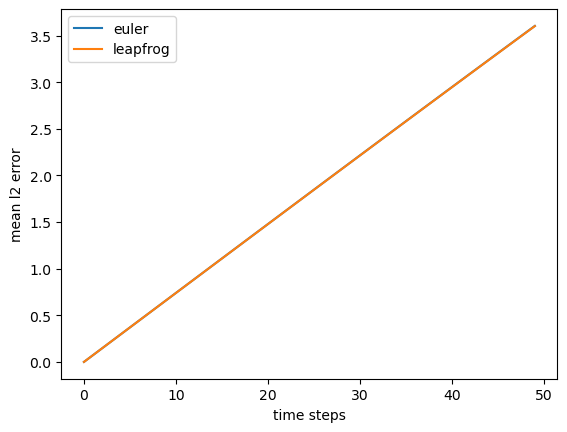

In [13]:
plt.plot(range(test_error_euler.shape[0]), test_error_euler.mean(axis = (1)), label = 'euler')
plt.plot(range(test_error_leapfrog.shape[0]), test_error_leapfrog.mean(axis = (1)), label = 'leapfrog')
plt.xlabel('time steps')
plt.ylabel('mean l2 error')
plt.legend()
plt.show()